<a href="https://www.kaggle.com/code/mmellinger66/spaceship-titanic-xgb-lgbm-blend?scriptVersionId=102001879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill">
    <h1 style="text-align: center;padding: 12px 0px 12px 0px;">Spaceship Titanic: XGBoost + LightGBM Blend</h1>
</div>

Ensembling models is important to doing well in Kaggle competitions.  This notebook is an attempt to combine two models, and build a foundation on which to combine several models.  Keeping this attempt simple, in accordance with the Telescope Rule:

Thomson's Rule for First-Time Telescope Makers: 

> "It is faster to make a four-inch mirror then a six-inch mirror than to make a six-inch mirror."

https://wiki.c2.com/?TelescopeRule


In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [2]:
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

from itertools import cycle

plt.style.use("ggplot")  # ggplot, fivethirtyeight
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [3]:
class Config:
    path = "../input/spaceship-titanic"
    gpu = False
    debug = False
    optimize = False
    model_type = "tf"  # (xgb, cat, lgbm, keras)
    model_name = "tf1"
    competition = "spaceship-titanic"
    calc_probability = True
    seed = 42
    N_ESTIMATORS = 1000  # 100, 300, 2000, 5000 GBDT

    batch_size = 64
    epochs = 25
    N_FOLDS = 10  # 5,10,15
    SEED_LENGTH = 1  # 5,10

### The target/dependent variable in the dataset

In [4]:
# Was the passenger transported?
TARGET = "Transported"

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that will be reused in each project.

I need to be better with [DRY](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) on Kaggle.

In [5]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [6]:
def create_submission(model_name, target, preds):
    sample_submission[target] = preds

    if len(model_name) > 0:
        fname = "submission_{model_name}.csv"
    else:
        fname = "submission.csv"

    sample_submission.to_csv(fname, index=False)

    return sample_submission

In [7]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)


def show_scores(gt, yhat):
    accuracy = accuracy_score(gt, yhat)
    precision = precision_score(gt, yhat)
    recall = recall_score(gt, yhat)
    f1 = f1_score(gt, yhat)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"f1: {f1:.4f}")

In [8]:
from sklearn.preprocessing import LabelEncoder


def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [9]:
from sklearn.preprocessing import OneHotEncoder


def one_hot_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = OneHotEncoder().fit_transform(train[col])
        test[col] = OneHotEncoder().fit_transform(test[col])
    return train, test

In [10]:
def show_missing_features(df):
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])

In [11]:
def create_folds(df, TARGET, n_folds=5, seed=42):
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

In [12]:
def show_fold_scores(scores):
    cv_score = np.mean(scores)  # Used in filename
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )

In [13]:
# Save OOF Results
if not os.path.exists("results"):
    os.makedirs("results")

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

## Load the following files

 - train.csv - Data used to build our machine learning model
 - test.csv - Data used to build our machine learning model. Does not contain the `Transported` target variable
 - sample_submission.csv - A file in the proper format to submit test predictions

In [14]:
train, test, sample_submission = read_data(Config.path)

train data: Rows=8693, Columns=14
test data : Rows=4277, Columns=13


In [15]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [16]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [17]:
train = train.drop(columns=["Name"], axis=1).copy()
# test = test.drop(columns=["PassengerId"], axis=1).copy()

## Categorical/Numerical Variables

In [18]:
## Separate Categorical and Numerical Features
cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
num_features = list(test.select_dtypes(include=["number"]).columns)
cat_features.remove("PassengerId")

FEATURES = cat_features + num_features
FEATURES

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Feature Engineering</h1>
</div>

In [19]:
train[FEATURES].head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,B/0/P,TRAPPIST-1e,False,39.0,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/0/S,TRAPPIST-1e,False,24.0,109.0,9.0,25.0,549.0,44.0
2,Europa,False,A/0/S,TRAPPIST-1e,True,58.0,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,A/0/S,TRAPPIST-1e,False,33.0,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,F/1/S,TRAPPIST-1e,False,16.0,303.0,70.0,151.0,565.0,2.0


# Extract Target and Drop Unused Columns

In [20]:
# y = train[TARGET]

# X = train_df.drop(columns=["PassengerId", TARGET], axis=1).copy()
# X = train[FEATURES].copy()

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Missing Values</h1>
</div>

Note, handling missing data is an entire subject that should be studied in detail.  Kaggle offers a [course](https://www.kaggle.com/learn/data-cleaning)

- [sklearn.impute.SimpleImputer](https://scikit-learn.org/stable/modules/impute.html)
- https://scikit-learn.org/stable/modules/impute.html

- [A Guide to Handling Missing values in Python](https://www.kaggle.com/parulpandey/a-guide-to-handling-missing-values-in-python)

In [21]:
show_missing_features(train)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
dtype: int64


In [22]:
from sklearn.impute import SimpleImputer

# Categorical
imputer = SimpleImputer(strategy="most_frequent")

train[cat_features] = imputer.fit_transform(train[cat_features])
test[cat_features] = imputer.transform(test[cat_features])

# Numerical

# imputer = SimpleImputer(strategy="mean")
imputer = SimpleImputer(strategy="median")  # median is more robust to outliers

train[num_features] = imputer.fit_transform(train[num_features])
test[num_features] = imputer.transform(test[num_features])

### At this point we no longer have missing values

In [23]:
show_missing_features(train)

Series([], dtype: int64)


# Encoding Categorical Features

Need to convert categorical features into numerical features.

In [24]:
train, test = label_encoder(
    train, test, ["Destination", "HomePlanet", "CryoSleep", "VIP", "Cabin"]
)
# X_test = pd.get_dummies(test[FEATURES], drop_first=True)

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,1,0,149,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,0,0,2184,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,0,0,2186,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True


In [25]:
# y = train[TARGET]
# X = train[FEATURES].copy()

# X_test = test[FEATURES].copy()

In [26]:
train = create_folds(train, TARGET, Config.N_FOLDS)

TARGET=Transported, n_folds=10, seed=42


In [27]:
submission_df = test[["PassengerId"]].copy()
#
oof = train[["PassengerId", TARGET, "fold"]].copy().reset_index(drop=True).copy()
oof.set_index("PassengerId", inplace=True)
oof.head()

,Transported,fold
PassengerId,,
0001_01,False,8
0002_01,True,5
0003_01,False,4
0003_02,False,4
0004_01,True,6


In [28]:
# oof = train[["PassengerId", TARGET, "fold"]].set_index("PassengerId")
# oof.head()

## Train Model

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Train Model with Cross Validation</h1>
</div>

### Some common functions

In [29]:
def process_valid_predictions(final_valid_predictions, train_id, model_name):
    model = f"pred_{model_name}"
    final_valid_predictions_df = pd.DataFrame.from_dict(
        final_valid_predictions, orient="index"
    ).reset_index()
    final_valid_predictions_df.columns = [train_id, model]
    final_valid_predictions_df.set_index(train_id, inplace=True)
    final_valid_predictions_df.sort_index(inplace=True)
    final_valid_predictions_df.to_csv(f"train_pred_{model_name}.csv", index=False)

    return final_valid_predictions_df

In [30]:
from scipy.stats import mode


def merge_test_predictions(final_test_predictions, calc_probability=True):

    if Config.calc_probability:
        print("Mean")
        result = np.mean(np.column_stack(final_test_predictions), axis=1)
    else:
        print("Mode")
        mode_result = mode(np.column_stack(final_test_predictions), axis=1)
        result = mode_result[0].ravel()

    return result

In [31]:
def train_xgb_model(
    df,
    test,
    get_model_fn,
    FEATURES,
    TARGET,
    calc_probability,
    rowid,
    params,
    n_folds=5,
    seed=42,
):

    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    # oof_preds = np.zeros((df.shape[0],)) # Zero array
    # print(f"oof_preds size={df.shape[0]}")
    #     print(
    #         f"\n===== XGBoost Estimators: {params['n_estimators']}, Random State: {seed} ====="
    #     )

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = (
            xvalid.PassengerId.values.tolist()
        )  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]
        xtrain.head()
        #         print(f"{yvalid}")
        model = get_model_fn()

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #             eval_metric="acc",  # auc
            verbose=False,
            #             early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        # Mean of the predictions
        #         preds_valid = model.predict(xvalid)
        #         test_preds = model.predict(xtest)
        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)

        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        fold_score = accuracy_score(yvalid, preds_valid_class)  # Validation Set Score
        #         fold_score = roc_auc_score(yvalid, preds_valid)  # Validation Set Score

        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Accuracy: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )

In [32]:
xgb_params = {
    "enable_categorical": True,
    "objective": "binary:logistic",
    "eval_metric": "logloss",  # auc
    "n_estimators": Config.N_ESTIMATORS,
    "learning_rate": 0.021138659045230178,
    "subsample": 0.4,
    "colsample_bytree": 0.91,
    "max_depth": 17,
    "gamma": 0.6000000000000001,
    "booster": "gbtree",
    "tree_method": "hist",
    "reg_lambda": 0.005882742898970815,
    "reg_alpha": 0.0014501578157205654,
    "random_state": 42,
    "n_jobs": 4,
    "min_child_weight": 5.567082153821453,
}

In [33]:
def get_xgb_clf_model():
    #     model = xgb.XGBClassifier(n_estimators=1000)
    model = xgb.XGBClassifier(**xgb_params)
    return model

In [34]:
# https://lightgbm.readthedocs.io/en/latest/Parameters.html

lgbm_params = {
    "n_estimators": Config.N_ESTIMATORS,
    #     "device_type": "gpu",
    #     "objective": "multiclass",
    #     "metric": "multi_logloss",
    "objective": "binary",
    "metric": "accuracy",  # auc
    "lambda_l1": 0.009130931198077825,
    "lambda_l2": 3.530680683338868e-05,
    #     "reg_alpha": 0.009130931198077825,
    #     "reg_lambda": 3.530680683338868e-05,
    "num_leaves": 430,
    "importance_type": "split",
    #     "learning_rate": 0.029330486500731102,
    "learning_rate": 0.1,
    "feature_fraction": 0.8757445736567416,
    "bagging_fraction": 0.9989307214277753,
    "bagging_freq": 10,
    "min_child_samples": 20,
    "random_state": 42,
    "n_jobs": -1,
}
if Config.gpu:
    lgbm_params["device_type"] = "gpu"

In [35]:
def get_lgbm_clf_model():
    model = lgb.LGBMClassifier(**lgbm_params)
    return model

In [36]:
model_name = "xgb1"  # Make the code more generic

In [37]:
(
    model,
    feature_importance_lst,
    fold_scores,
    final_valid_predictions,
    final_test_predictions,
) = train_xgb_model(
    train,
    test,
    get_xgb_clf_model,
    FEATURES,
    TARGET,
    Config.calc_probability,
    "PassengerId",
    xgb_params,
    Config.N_FOLDS,
    Config.seed,
)

========== Fold 1/10 ==========
fold: 1, Accuracy: 0.7839080459770115, Run Time: 7.82
========== Fold 2/10 ==========
fold: 2, Accuracy: 0.8068965517241379, Run Time: 9.16
========== Fold 3/10 ==========
fold: 3, Accuracy: 0.8183908045977012, Run Time: 7.84
========== Fold 4/10 ==========
fold: 4, Accuracy: 0.7721518987341772, Run Time: 7.77
========== Fold 5/10 ==========
fold: 5, Accuracy: 0.807825086306099, Run Time: 7.67
========== Fold 6/10 ==========
fold: 6, Accuracy: 0.7951668584579977, Run Time: 9.22
========== Fold 7/10 ==========
fold: 7, Accuracy: 0.7767548906789413, Run Time: 7.86
========== Fold 8/10 ==========
fold: 8, Accuracy: 0.7986191024165707, Run Time: 8.14
========== Fold 9/10 ==========
fold: 9, Accuracy: 0.7859608745684695, Run Time: 7.70
========== Fold 10/10 ==========
fold: 10, Accuracy: 0.7733026467203682, Run Time: 9.25


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Scores</h1>
</div>

CV, or Cross Validation, Score.

We average the means and the standard deviations.

The Adjusted Score is the average of the means minus the average of standard deviation. Do this to attempt to get one number to evaluate the score when comparing different models.

In [38]:
show_fold_scores(fold_scores)

Scores -> Adjusted: 0.77673043 , mean: 0.79189768, std: 0.01516725


In [39]:
final_valid_predictions_df = process_valid_predictions(
    final_valid_predictions, "id", model_name
)
final_valid_predictions_df.head()

,pred_xgb1
id,
0001_01,0.602499
0002_01,0.045538
0003_01,0.015485
0003_02,0.007215
0004_01,0.049893


In [40]:
oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]
oof.head()

,Transported,fold,pred_xgb1
PassengerId,,,
0001_01,False,8,0.602499
0002_01,True,5,0.045538
0003_01,False,4,0.015485
0003_02,False,4,0.007215
0004_01,True,6,0.049893


In [41]:
result = merge_test_predictions(final_test_predictions, Config.calc_probability)
result[:20]

Mean


array([0.77630615, 0.00856763, 0.99087065, 0.98124516, 0.5528081 ,
       0.7141057 , 0.9858645 , 0.99185073, 0.9952394 , 0.7495244 ,
       0.15664284, 0.16572413, 0.8457259 , 0.9814044 , 0.01382567,
       0.16699943, 0.38853294, 0.97365904, 0.81866515, 0.00561676],
      dtype=float32)

In [42]:
# submission_df["target_xgb1"] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission_df[f"target_{model_name}"] = result
submission_df.head(10)

,PassengerId,target_xgb1
0,0013_01,0.776306
1,0018_01,0.008568
2,0019_01,0.990871
3,0021_01,0.981245
4,0023_01,0.552808
5,0027_01,0.714106
6,0029_01,0.985865
7,0032_01,0.991851
8,0032_02,0.995239
9,0033_01,0.749524


In [43]:
ss = (
    submission_df[["PassengerId", f"target_{model_name}"]].copy().reset_index(drop=True)
)
ss.rename(columns={f"target_{model_name}": TARGET}, inplace=True)
ss

,PassengerId,Transported
0,0013_01,0.776306
1,0018_01,0.008568
2,0019_01,0.990871
3,0021_01,0.981245
4,0023_01,0.552808
...,...,...
4272,9266_02,0.864188
4273,9269_01,0.081078
4274,9271_01,0.986516
4275,9273_01,0.976216


In [44]:
ss[TARGET] = np.rint(ss[TARGET]).astype(bool)
ss.to_csv(
    f"submission_{model_name}.csv", index=False
)  # Can submit the individual model
ss.head(10)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True


## LGBM Model

In [45]:
model_name = "lgbm1"  # Make the code more generic

In [46]:
(
    model,
    feature_importance_lst,
    fold_scores,
    final_valid_predictions,
    final_test_predictions,
) = train_xgb_model(
    train,
    test,
    get_lgbm_clf_model,
    FEATURES,
    TARGET,
    Config.calc_probability,
    "PassengerId",
    lgbm_params,
    Config.N_FOLDS,
    Config.seed,
)

========== Fold 1/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 1, Accuracy: 0.774712643678161, Run Time: 9.30
========== Fold 2/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 2, Accuracy: 0.7804597701149425, Run Time: 9.28
========== Fold 3/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 3, Accuracy: 0.8045977011494253, Run Time: 10.87
========== Fold 4/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 4, Accuracy: 0.7537399309551208, Run Time: 9.14
========== Fold 5/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 5, Accuracy: 0.766398158803222, Run Time: 9.17
========== Fold 6/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 6, Accuracy: 0.7640966628308401, Run Time: 9.46
========== Fold 7/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 7, Accuracy: 0.7721518987341772, Run Time: 9.42
========== Fold 8/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 8, Accuracy: 0.7940161104718066, Run Time: 9.80
========== Fold 9/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 9, Accuracy: 0.7790563866513234, Run Time: 9.14
========== Fold 10/10 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 10, Accuracy: 0.761795166858458, Run Time: 10.22


In [47]:
show_fold_scores(fold_scores)

Scores -> Adjusted: 0.76057240 , mean: 0.77510244, std: 0.01453004


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Save OOF Predictions</h1>
</div>

This is unused for this example but needed later for [Blending](https://towardsdatascience.com/ensemble-learning-stacking-blending-voting-b37737c4f483).

**General idea**: The values will be use to create new features in a blended model.

- [Stacking and Blending — An Intuitive ExplanationStacking and Blending — An Intuitive Explanation](https://medium.com/@stevenyu530_73989/stacking-and-blending-intuitive-explanation-of-advanced-ensemble-methods-46b295da413chttps://medium.com/@stevenyu530_73989/stacking-and-blending-intuitive-explanation-of-advanced-ensemble-methods-46b295da413c)

In [48]:
final_valid_predictions_df = process_valid_predictions(
    final_valid_predictions, "PassengerId", model_name
)
final_valid_predictions_df.head()

,pred_lgbm1
PassengerId,
0001_01,0.980238
0002_01,0.001876
0003_01,0.000041
0003_02,0.000008
0004_01,0.000066


In [49]:
oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]
oof.head()

,Transported,fold,pred_xgb1,pred_lgbm1
PassengerId,,,,
0001_01,False,8,0.602499,0.980238
0002_01,True,5,0.045538,0.001876
0003_01,False,4,0.015485,0.000041
0003_02,False,4,0.007215,0.000008
0004_01,True,6,0.049893,0.000066


In [50]:
result = merge_test_predictions(final_test_predictions, Config.calc_probability)
result[:20]

Mean


array([9.23713476e-01, 4.32279544e-06, 9.96911435e-01, 9.99984702e-01,
       8.02249528e-01, 9.55960598e-01, 9.99991197e-01, 9.99999691e-01,
       9.99999702e-01, 9.26303323e-01, 1.18144201e-02, 8.90954233e-03,
       9.94896377e-01, 9.99966923e-01, 5.08981550e-06, 4.37809080e-04,
       1.28499563e-01, 9.99986669e-01, 9.32074074e-01, 3.11505593e-06])

In [51]:
submission_df[f"target_{model_name}"] = result
submission_df.head(10)

,PassengerId,target_xgb1,target_lgbm1
0,0013_01,0.776306,0.923713
1,0018_01,0.008568,0.000004
2,0019_01,0.990871,0.996911
3,0021_01,0.981245,0.999985
4,0023_01,0.552808,0.802250
5,0027_01,0.714106,0.955961
6,0029_01,0.985865,0.999991
7,0032_01,0.991851,1.000000
8,0032_02,0.995239,1.000000
9,0033_01,0.749524,0.926303


In [52]:
ss = (
    submission_df[["PassengerId", f"target_{model_name}"]].copy().reset_index(drop=True)
)
ss.rename(columns={f"target_{model_name}": TARGET}, inplace=True)
ss

,PassengerId,Transported
0,0013_01,0.923713
1,0018_01,0.000004
2,0019_01,0.996911
3,0021_01,0.999985
4,0023_01,0.802250
...,...,...
4272,9266_02,0.999265
4273,9269_01,0.002644
4274,9271_01,0.999999
4275,9273_01,0.999993


In [53]:
ss[TARGET] = np.rint(ss[TARGET]).astype(bool)
ss.to_csv(f"submission_{model_name}.csv", index=False)
ss.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Weighted Blend Based on OOF</h1>
</div>

In [54]:
oof.head()

,Transported,fold,pred_xgb1,pred_lgbm1
PassengerId,,,,
0001_01,False,8,0.602499,0.980238
0002_01,True,5,0.045538,0.001876
0003_01,False,4,0.015485,0.000041
0003_02,False,4,0.007215,0.000008
0004_01,True,6,0.049893,0.000066


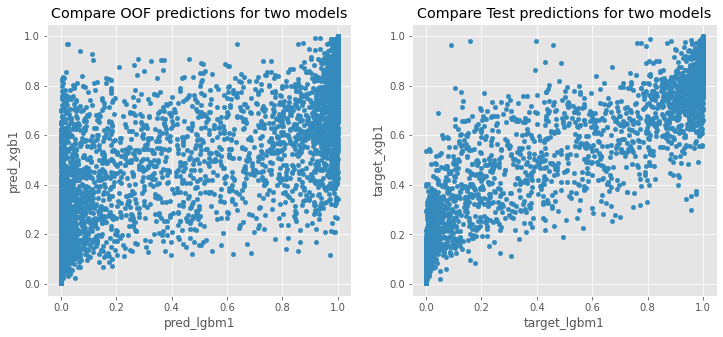

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
oof.plot(
    x="pred_lgbm1",
    y="pred_xgb1",
    kind="scatter",
    title="Compare OOF predictions for two models",
    ax=axs[0],
)

submission_df.plot(
    x="target_lgbm1",
    y="target_xgb1",
    kind="scatter",
    title="Compare Test predictions for two models",
    ax=axs[1],
)
plt.show()

In [56]:
oof.head()

,Transported,fold,pred_xgb1,pred_lgbm1
PassengerId,,,,
0001_01,False,8,0.602499,0.980238
0002_01,True,5,0.045538,0.001876
0003_01,False,4,0.015485,0.000041
0003_02,False,4,0.007215,0.000008
0004_01,True,6,0.049893,0.000066


In [57]:
def get_oof_accuracy_score(weight, oof, pred_model1, pred_model2):
    blend_pred = (oof[pred_model1] * weight) + (oof[pred_model2] * (1 - weight))
    blend_int = np.rint(blend_pred).astype(int)
    score = accuracy_score(oof[TARGET], blend_int)
    return score

In [58]:
myscores = {}
best = 0
best_weight = 0

for weight in range(100):
    weight /= 100
    score = get_oof_accuracy_score(weight, oof, "pred_xgb1", "pred_lgbm1")
    if score > best:
        best = score
        best_weight = weight
        print(f"Best Weight: {best_weight},Score {best}")
    myscores[weight] = score

Best Weight: 0.0,Score 0.7751064074542735
Best Weight: 0.04,Score 0.7753364776256758
Best Weight: 0.05,Score 0.775451512711377
Best Weight: 0.2,Score 0.7757966179684804
Best Weight: 0.21,Score 0.7759116530541815
Best Weight: 0.23,Score 0.7762567583112849
Best Weight: 0.24,Score 0.776371793396986
Best Weight: 0.25,Score 0.7767168986540895
Best Weight: 0.27,Score 0.7769469688254917
Best Weight: 0.28,Score 0.7772920740825952
Best Weight: 0.31,Score 0.7776371793396986
Best Weight: 0.32,Score 0.7783273898539055
Best Weight: 0.33,Score 0.7784424249396066
Best Weight: 0.34,Score 0.77878753019671
Best Weight: 0.35,Score 0.7790176003681123
Best Weight: 0.36,Score 0.7794777407109168
Best Weight: 0.37,Score 0.779592775796618
Best Weight: 0.39,Score 0.7797078108823191
Best Weight: 0.4,Score 0.7800529161394225
Best Weight: 0.41,Score 0.7802829863108248
Best Weight: 0.46,Score 0.7805130564822271
Best Weight: 0.49,Score 0.7807431266536293
Best Weight: 0.5,Score 0.7812032669964339
Best Weight: 0.51,Sc

In [59]:
blend_results = pd.DataFrame(myscores, index=["score"]).T

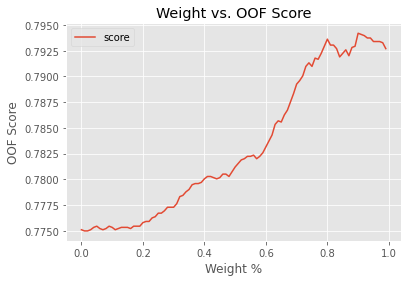

In [60]:
ax = blend_results.plot(title="Weight vs. OOF Score")
ax.set_ylabel("OOF Score")
ax.set_xlabel("Weight %")

plt.show()

### The Blended Weight is ...

In [61]:
blend_results.loc[blend_results["score"] == blend_results["score"].max()]

,score
0.9,0.794202


In [62]:
blend_score = blend_results["score"].max()
print(f"Blended Score: {blend_score:.8f}")

Blended Score: 0.79420223


In [63]:
w = blend_results.loc[blend_results["score"] == blend_results["score"].max()]
w

,score
0.9,0.794202


In [64]:
wt = w.first_valid_index()
wt

0.9

In [65]:
blend_results["score"]

0.00    0.775106
0.01    0.774991
0.02    0.774991
0.03    0.775106
0.04    0.775336
          ...   
0.95    0.793397
0.96    0.793397
0.97    0.793397
0.98    0.793282
0.99    0.792707
Name: score, Length: 100, dtype: float64

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Submission File</h1>
</div>

In [66]:
submission_df.head()

,PassengerId,target_xgb1,target_lgbm1
0,0013_01,0.776306,0.923713
1,0018_01,0.008568,0.000004
2,0019_01,0.990871,0.996911
3,0021_01,0.981245,0.999985
4,0023_01,0.552808,0.802250


In [67]:
print(f"Weights=({wt}, {1-wt})")

sample_submission[TARGET] = (submission_df["target_xgb1"] * wt) + (
    submission_df["target_lgbm1"] * (1 - wt)
)
sample_submission.head(8)

Weights=(0.9, 0.09999999999999998)


,PassengerId,Transported
0,0013_01,0.791047
1,0018_01,0.007711
2,0019_01,0.991475
3,0021_01,0.983119
4,0023_01,0.577752
5,0027_01,0.738291
6,0029_01,0.987277
7,0032_01,0.992666


In [68]:
sample_submission[TARGET] = np.rint(sample_submission[TARGET]).astype(bool)
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head(8)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
